<a href="https://colab.research.google.com/github/sgr1118/Kaggle-Transcription/blob/main/%5Bfilb03_4%5DNatural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 캐글 API 불러오기
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rlfkr1234","key":"cf174d7e08b9e8738f8815cd6a5ad980"}'}

In [2]:
!ls -1ha kaggle.json
# kaggle json 파일 업로드 확인

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 111MB/s]


In [5]:
# 불러온 파일이 알집인 경우 
!unzip /content/nlp-getting-started.zip

Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [8]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# 필요한 라이브러리 불러오기

import numpy as np 
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk 
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import BlanklineTokenizer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
import string
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
import scikitplot as skplt
from nltk.tokenize import word_tokenize
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from multiprocessing import Pool

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
# 데이터 불러오기

train_data = pd.read_csv('/content/train.csv')
test_data  = pd.read_csv('/content/test.csv')

In [12]:
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


id : 각 트윗에 대한 고유 id

keyword : 트윗 문장속에 특정한 키워드 (아마 공란일 것이다)

location : 트윗을 작성한 장소 (아마 공란일 것이다)

text : 트윗 본문

target : 실제 재난인지 아닌지 구분, 실제 재난은 1, 아니면 0

In [13]:
# rows, columns 수 확인

print('There are {} rows and {} colimns in train'.format(train_data.shape[0], train_data.shape[1]))

print('There are {} rows and {} colimns in test'.format(test_data.shape[0], test_data.shape[1]))

There are 7613 rows and 5 colimns in train
There are 3263 rows and 4 colimns in test


In [14]:
# columns type 확인

print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [16]:
# 'text' 임의 확인

train_data['text'][11]

'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding'

# EDA

Target variable distribution

traget column의 데이터 분포 확인

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

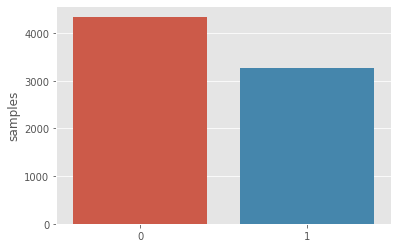

In [20]:
x = train_data.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

# 비 재난 트위터보다 재난 트위터의 숫자가 더 적다

Explaratory analysis of tweets

문자, 단어, 문장 수준 데이터 분석 하기

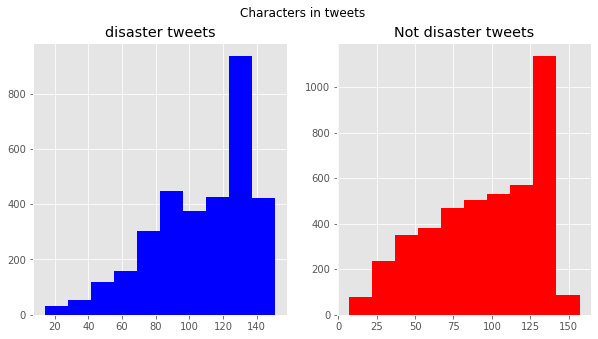

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# 실제 재난 트위터
tweet_len = train_data[train_data['target'] == 1]['text'].str.len()
ax1.hist(tweet_len, color = 'b')
ax1.set_title('disaster tweets')

# 비 재난 트위터
tweet_len = train_data[train_data['target'] == 0]['text'].str.len()
ax2.hist(tweet_len, color = 'r')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

# 두 트위터 문장 길이는 120 ~ 145에서 많은 분포가 있다.

Number of words in a tweet

트위터 문장 속에 단어 개수 출력

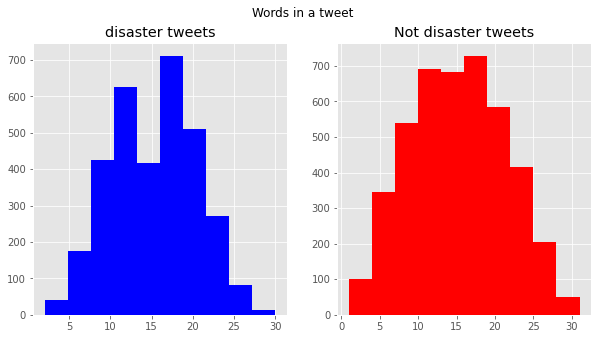

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# 재난 트위터
tweet_len = train_data[train_data['target'] == 1]['text'].str.split().map(lambda x : len(x))
ax1.hist(tweet_len, color = 'b')
ax1.set_title('disaster tweets')

# 비 재난 트위터
tweet_len = train_data[train_data['target'] == 0]['text'].str.split().map(lambda x : len(x))
ax2.hist(tweet_len, color = 'r')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

# 재난 트위터는 10 ~ 15, 17~20 단어에서 많은 분포가 확인
# 비 재난 트위터는 정규분포같은 형태를 띄고있다.

Average word length in a tweet

트위터 문장 속 단어의 평균 길이

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

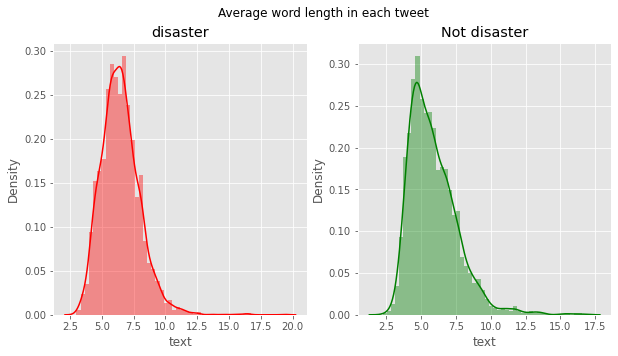

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# 재난 트위터
word = train_data[train_data['target'] == 1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x : np.mean(x)), ax = ax1, color = 'r')
ax1.set_title('disaster')

# 비 재난 트위터
word = train_data[train_data['target'] == 0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x : np.mean(x)), ax = ax2, color = 'g')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

# 재난, 비 재난 트위터 모두 문장 속 단어의 평균 길이는 유사하게 나타남.

말뭉치 속 단어의 빈도 확인하기

In [58]:
corpus = []

for x in train_data['text'].str.split():
  for i in x:
    corpus.append(i)

[유사 딕셔너리 활용법](https://dongdongfather.tistory.com/69)

<BarContainer object of 30 artists>

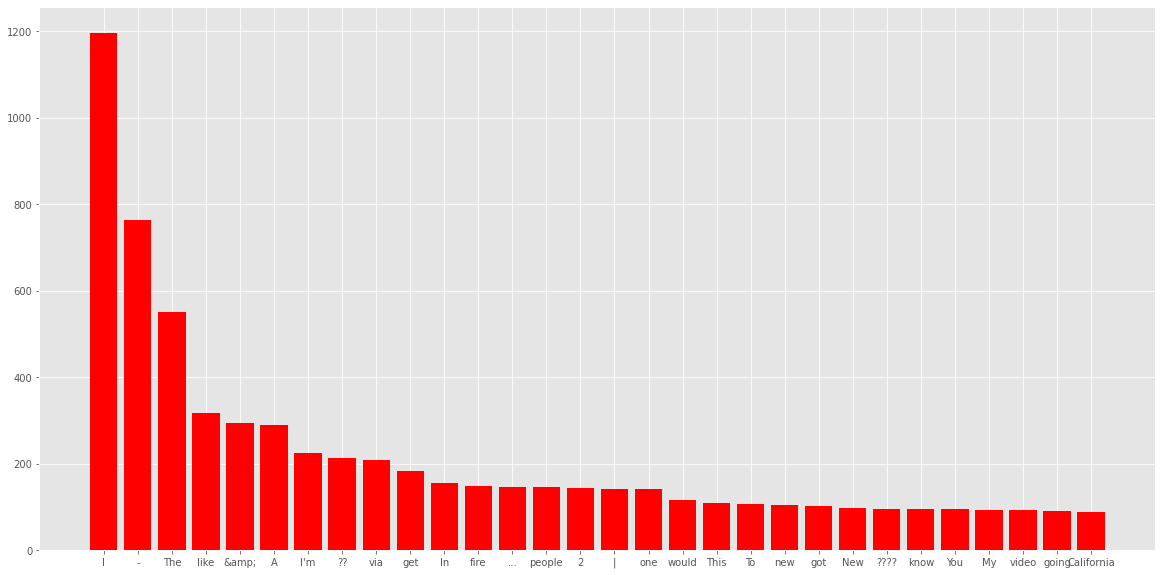

In [59]:
dic = defaultdict(int)
dic = defaultdict(int)

for word in corpus:
  if word not in stop:
    dic[word] += 1

top = sorted(dic.items(), key = lambda x : x[1], reverse = True)[:30]

x,y = zip(*top)
plt.rcParams['figure.figsize'] = (20, 10)
plt.bar(x, y, color = 'r')

# stopword를 제거하지 않았기 때문에 'I' 같은 조사, 접미사가 높은 빈도를 보이고있다.

<BarContainer object of 30 artists>

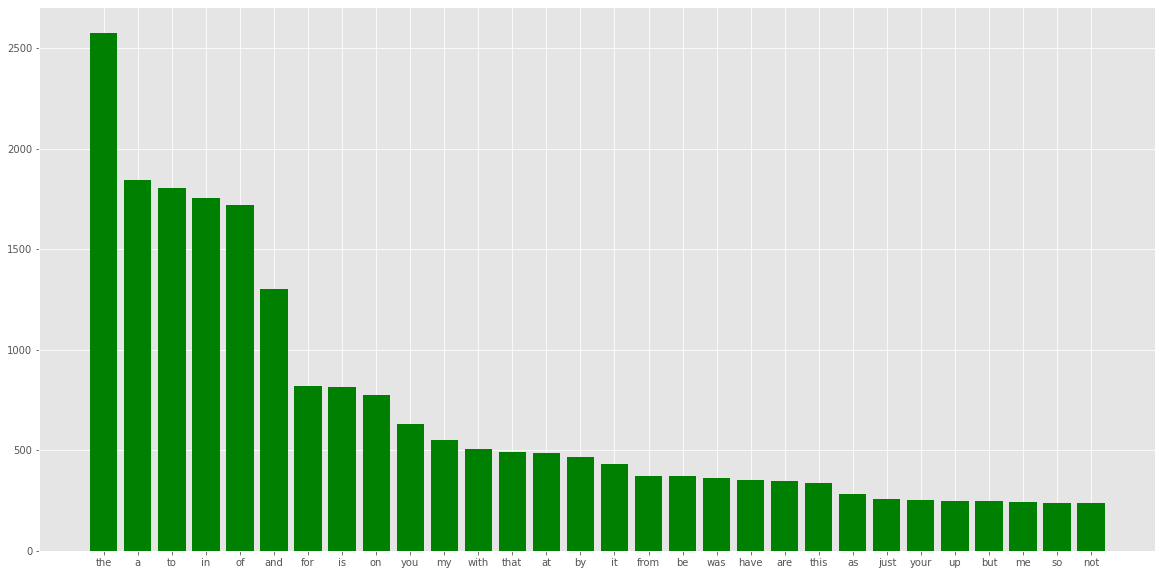

In [60]:
stop = stopwords.words('english')

dic = defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word] += 1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:30] 

x,y=zip(*top)
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x, y, color = 'g')

# 불용어를 제거하면 방금 전 단어 빈도와는 다소 다른 그래프가 그려진다.

구두점 빈도 출력하기

<BarContainer object of 23 artists>

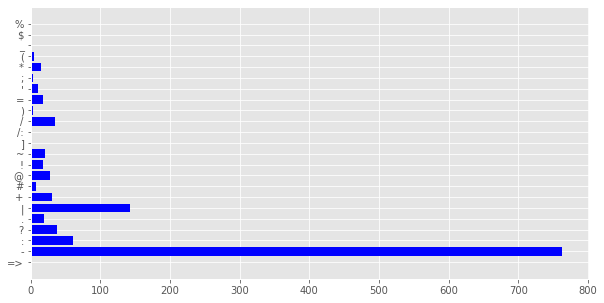

In [32]:
from scipy import special
plt.figure(figsize=(10,5))

dic = defaultdict(int)
special = string.punctuation
for i in (corpus):
  if i in special:
    dic[i] += 1

x,y = zip(*dic.items())
plt.barh(x,y ,color = 'b')

비 재난 트위터 문장 속에 단어 빈도 보기

[Counter 역할](https://www.daleseo.com/python-collections-counter/)

Counter 생성자에 문자열을 인자로 넘기면 각 문자가 문자열에서 몇 번씩 나타나는지를 알려주는 객체가 반환됩니다.



In [33]:
words = train_data[train_data.target == 0].text.apply(lambda x : [word.lower() for word in x.split()])

h_words = Counter()

for text_ in words:
  h_words.update(text_)

print(h_words.most_common(50)) # 데이터의 개수가 많은 순으로 50개만 정렬

[('the', 1877), ('a', 1238), ('to', 1181), ('i', 1052), ('and', 911), ('of', 895), ('in', 805), ('you', 625), ('is', 586), ('my', 541), ('for', 486), ('on', 424), ('with', 374), ('-', 374), ('that', 357), ('it', 341), ('this', 286), ('be', 284), ('like', 250), ('have', 240), ('by', 240), ('so', 235), ('are', 231), ('at', 229), ('just', 229), ('your', 225), ('me', 221), ('was', 216), ('but', 216), ('not', 198), ("i'm", 195), ('&amp;', 190), ('??', 183), ('out', 179), ('up', 178), ('will', 177), ('if', 177), ('from', 177), ('all', 173), ('new', 163), ('get', 161), ('as', 160), ('or', 155), ('we', 148), ('when', 144), ('has', 143), ('he', 143), ('no', 140), ('about', 139), ('they', 133)]


재난 트위터 문장 속에 단어 빈도 보기

In [34]:
words = train_data[train_data.target==1].text.apply(lambda x: [word.lower() for word in x.split()])
h_words = Counter()

for text_ in words:
  h_words.update(text_)
    
print(h_words.most_common(50)) # 데이터의 개수가 많은 순으로 50개만 정렬

[('the', 1330), ('in', 1144), ('of', 919), ('a', 897), ('to', 753), ('and', 494), ('on', 410), ('for', 394), ('-', 389), ('is', 344), ('at', 303), ('i', 284), ('by', 274), ('from', 243), ('with', 188), ('that', 181), ('after', 181), ('this', 177), ('as', 167), ('are', 166), ('was', 165), ('it', 163), ('fire', 151), ('have', 140), ('my', 130), ('over', 123), ('you', 121), ('more', 121), ('via', 117), ('up', 114), ('an', 113), ('be', 112), ('...', 106), ('&amp;', 105), ('has', 104), ('suicide', 103), ('who', 100), ('no', 99), ('disaster', 97), ('but', 95), ('police', 94), ('people', 93), ('been', 93), ('when', 93), ('killed', 92), ('like', 91), ('not', 90), ('california', 88), ('than', 85), ('just', 84)]


Explaratory analysis of Other Variables

keyword와 location에서 결측치 확인하기

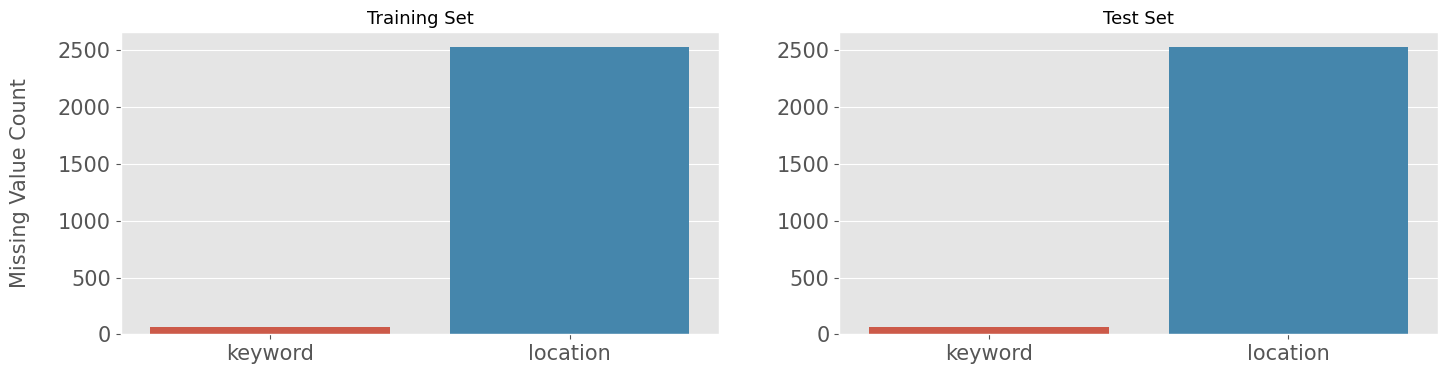

In [61]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols = 2, figsize = (17, 4), dpi = 100)

sns.barplot(x = train_data[missing_cols].isnull().sum().index,
            y = train_data[missing_cols].isnull().sum().values, ax = axes[0])
sns.barplot(x = train_data[missing_cols].isnull().sum().index,
            y = train_data[missing_cols].isnull().sum().values, ax = axes[1])

axes[0].set_ylabel('Missing Value Count', size = 15, labelpad = 20)
axes[0].tick_params(axis = 'x', labelsize = 15)
axes[0].tick_params(axis = 'y', labelsize = 15)
axes[1].tick_params(axis = 'x', labelsize = 15)
axes[1].tick_params(axis = 'y', labelsize = 15)

axes[0].set_title('Training Set', fontsize = 13)
axes[1].set_title('Test Set', fontsize = 13)

plt.show()

for df in [train_data, test_data]:
  for col in missing_cols:
    df[col] = df[col].fillna(f'no_{col}')

In [62]:
df

,id,keyword,location,text
0,0,no_keyword,no_location,Just happened a terrible car crash
1,2,no_keyword,no_location,"Heard about #earthquake is different cities, s..."
2,3,no_keyword,no_location,"there is a forest fire at spot pond, geese are..."
3,9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires
4,11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,no_keyword,no_location,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,no_keyword,no_location,Storm in RI worse than last hurricane. My city...
3260,10868,no_keyword,no_location,Green Line derailment in Chicago http://t.co/U...
3261,10874,no_keyword,no_location,MEG issues Hazardous Weather Outlook (HWO) htt...


location은 자동적으로 생성되지 않기에 정리되지 않은 text가 많다. 즉 unique한 text가 많다는 것이다.

In [63]:
print(f'Number of unique vlaues in keyword = {train_data["keyword"].nunique()} (Training) - {test_data["keyword"].nunique()} (Test)')
print(f'Number of unique vlaues in location = {train_data["location"].nunique()} (Training) - {test_data["location"].nunique()} (Test)')

Number of unique vlaues in keyword = 222 (Training) - 222 (Test)
Number of unique vlaues in location = 3342 (Training) - 1603 (Test)


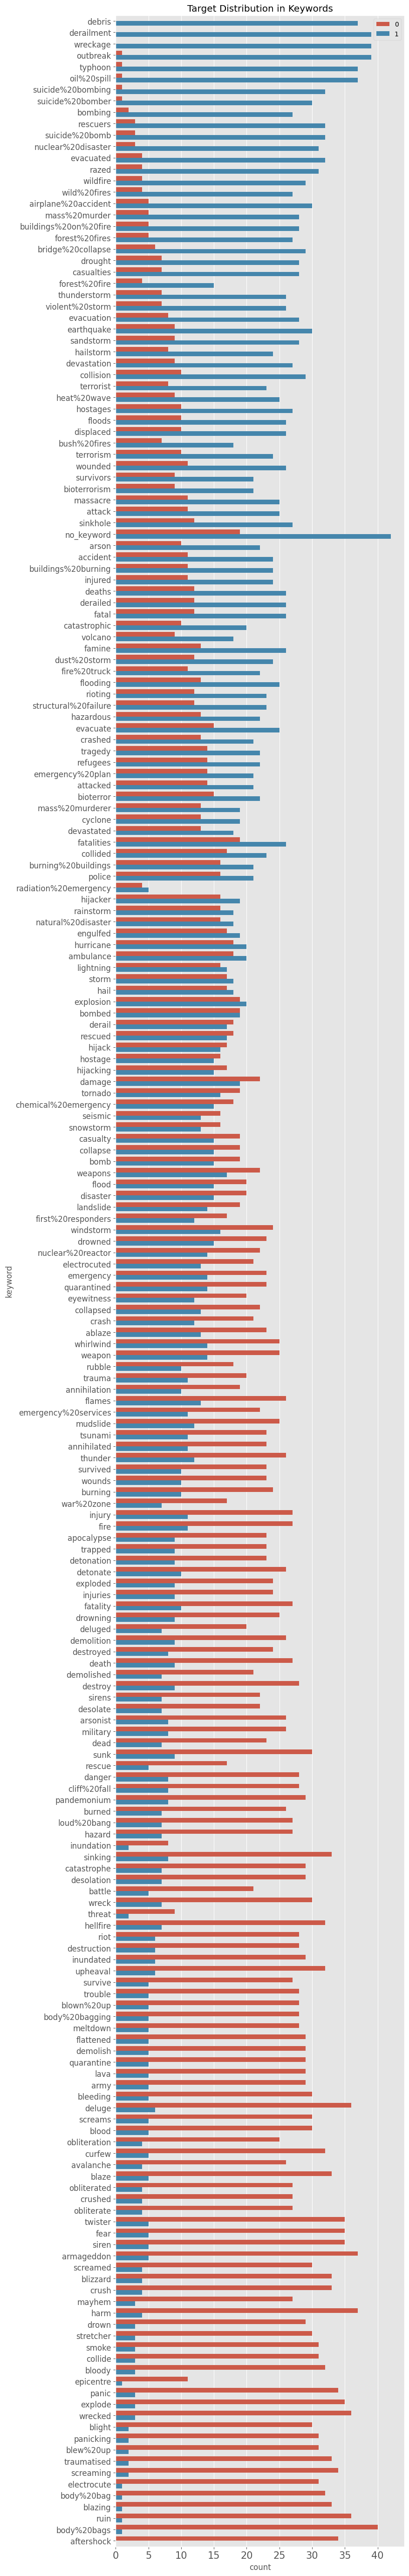

In [64]:
train_data['target_mean'] = train_data.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi = 100)

sns.countplot(y = train_data.sort_values(by = 'target_mean', ascending = False)['keyword'],
              hue = train_data.sort_values(by = 'target_mean', ascending = False)['target'])

plt.tick_params(axis = 'x', labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 12)
plt.legend(loc = 1)
plt.title('Target Distribution in Keywords')

plt.show()

train_data.drop(columns=['target_mean'], inplace=True)

# Hashtag analysis

문자 속에서 4자리 숫자를 찾기 위하여 정규 표현식을 사용하여 준다.

[python 이모티콘 제거 참고](https://www.programcreek.com/python/?CodeExample=remove+emoji)

In [65]:
def clean_text(df, text_field, new_text_field_name):
  df[new_text_field_name] = df[text_field].str.lower() # 소문자화
  df[new_text_field_name] = df[new_text_field_name].apply(lambda elem : re.sub(r"\d+", '', elem)) # url 제거
  df[new_text_field_name] = df[new_text_field_name].apply(lambda elem : re.sub(r"htpps?://\S+|www.\.\.S+", '', elem)) # HTML tag 제거
  df[new_text_field_name] = df[new_text_field_name].apply(lambda elem : re.sub(r"<.*?>", "", elem)) # 이모티콘 제거
  df[new_text_field_name] = df[new_text_field_name].apply(lambda elem : re.sub(r"["
    u"\U0001F600-\U0001F64F"  # 이모티콘
    u"\U0001F300-\U0001F5FF"  # 기호 및 그림 문자
    u"\U0001F680-\U0001F6FF"  # 교통 및 지도 기호
    u"\U0001F1E0-\U0001F1FF"  # 플래그 (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
  "]+", '', elem))

  return df

data_clean = clean_text(train_data, 'text', 'text_clean')
data_clean_test = clean_text(test_data,'text', 'text_clean')
data_clean.head()

,id,keyword,location,text,target,text_clean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


# Removing Stop words

불용어는 NLP에서 분석 결과에 도움을 주지 않기에 제거하는 것이 좋다.

In [66]:
data_clean['text_clean'] = data_clean['text_clean'].apply(lambda x : ' '.join
                                                          ([word for word in x.split() if word not in (stop)]))
data_clean.head()

,id,keyword,location,text,target,text_clean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,deeds reason #earthquake may allah forgive us
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...


# Tokenizing

토큰화는 문자열, 텍스트를 토큰 목록으로 토큰화하거나 분할하는 프로세스입니다.

토큰은 단어가 문장의 토큰이고 문장이 단락의 토큰인 것처럼 토큰을 부분으로 생각할 수 있습니다.




In [67]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_clean['text_tokens'] = data_clean['text_clean'].apply(lambda x : word_tokenize(x))
data_clean.head()

,id,keyword,location,text,target,text_clean,text_tokens
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,deeds reason #earthquake may allah forgive us,"[deeds, reason, #, earthquake, may, allah, for..."
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, ., canada]"
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...,"[residents, asked, 'shelter, place, ', notifie..."
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ...","[,, people, receive, #, wildfires, evacuation,..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...,"[got, sent, photo, ruby, #, alaska, smoke, #, ..."


Stemming (어간 추출)

어간(Stem)을 추출하는 작업을 어간 추출(stemming)이라고 합니다. 어간 추출은 형태학적 분석을 단순화한 버전이라고 볼 수도 있고, 정해진 규칙만 보고 단어의 어미를 자르는 어림짐작의 작업이라고 볼 수도 있습니다. 

이 작업은 섬세한 작업이 아니기 때문에 어간 추출 후에 나오는 결과 단어는 사전에 존재하지 않는 단어일 수도 있습니다. 

In [52]:
# 어간 추출

from nltk.stem.porter import PorterStemmer

porter_stemmer = PorterStemmer()
text = 'studies syudying cries cry'
tokenization = nltk.word_tokenize(text)
for w in tokenization:
  print('Stemming for {} is {}'.format(w,porter_stemmer.stem(w)))

Stemming for studies is studi
Stemming for syudying is syudi
Stemming for cries is cri
Stemming for cry is cri


In [68]:
# 어간 및 표제어 추출 함수 작성

def word_stemmer(text):
  stem_text = [PorterStemmer().stem(i) for i in text]
  return stem_text

data_clean['text_clean_tokens'] = data_clean['text_tokens'].apply(lambda x : word_stemmer(x))

data_clean.head()

,id,keyword,location,text,target,text_clean,text_tokens,text_clean_tokens
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,deeds reason #earthquake may allah forgive us,"[deeds, reason, #, earthquake, may, allah, for...","[deed, reason, #, earthquak, may, allah, forgi..."
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, rong, sask, ., canada]"
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...,"[residents, asked, 'shelter, place, ', notifie...","[resid, ask, 'shelter, place, ', notifi, offic..."
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ...","[,, people, receive, #, wildfires, evacuation,...","[,, peopl, receiv, #, wildfir, evacu, order, c..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...,"[got, sent, photo, ruby, #, alaska, smoke, #, ...","[got, sent, photo, rubi, #, alaska, smoke, #, ..."


Lemmatization (표제어 추출)

표제어(Lemma)는 한글로는 '표제어' 또는 '기본 사전형 단어' 정도의 의미를 갖습니다. 

표제어 추출은 단어들로부터 표제어를 찾아가는 과정입니다. 표제어 추출은 단어들이 다른 형태를 가지더라도, 그 뿌리 단어를 찾아가서 단어의 개수를 줄일 수 있는지 판단합니다.

예를 들어서 am, are, is는 서로 다른 스펠링이지만 그 뿌리 단어는 be라고 볼 수 있습니다. 이때, 이 단어들의 표제어는 be라고 합니다.

In [54]:
# 표제어 추출
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
text = 'studies studying cries cry'
tokenization = nltk.word_tokenize(text)

for w in tokenization:
  print('Lemma for {} is {}'.format(w, wordnet_lemmatizer.lemmatize(w)))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Lemma for studies is study
Lemma for studying is studying
Lemma for cries is cry
Lemma for cry is cry


In [69]:
def word_lemmatizer(text):
  lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
  return lem_text

data_clean['text_clean_tokens'] = data_clean['text_tokens'].apply(lambda x : word_lemmatizer(x))

data_clean.head()

,id,keyword,location,text,target,text_clean,text_tokens,text_clean_tokens
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,deeds reason #earthquake may allah forgive us,"[deeds, reason, #, earthquake, may, allah, for...","[deed, reason, #, earthquake, may, allah, forg..."
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, ., canada]"
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...,"[residents, asked, 'shelter, place, ', notifie...","[resident, asked, 'shelter, place, ', notified..."
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ...","[,, people, receive, #, wildfires, evacuation,...","[,, people, receive, #, wildfire, evacuation, ..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...,"[got, sent, photo, ruby, #, alaska, smoke, #, ...","[got, sent, photo, ruby, #, alaska, smoke, #, ..."


Why is Lemmatization better than Stemming?

[]()

Splitting the data 

학습 / 테스트 데이터 나누기

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(data_clean['text_clean'],
                                                    data_clean['target'],
                                                    test_size = 0.2,
                                                    random_state = 10)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(6090,) (1523,) (6090,) (1523,)


Bag of Words - Countvectorizer Features

Countvectorizer 파라미터 설명

- analyzer : 문자열 {'word','char','char_wb'}



In [71]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range=(1,1))
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(), index = ['sentence' + str(i) for i in range(1, 1 + len(X_train))],
             columns = vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,__,__ohhmyjoshh,__scrambledeggs,__srajapakse__,_animaladvocate,_ashj,_asianshawtyy,_bookofdaniel,_charleyisqueen,_dangdaddy,...,ûïyou,ûò,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe
sentence1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence6086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# 최소 알파벳이 3자 이상 포함된 문자 카운트하기

vectorizer = CountVectorizer(analyzer = 'word', token_pattern = r'\b[a-zA-Z]{3,}\b',ngram_range=(1,1))
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(), index = ['sentence' + str(i) for i in range(1, 1 + len(X_train))],
             columns = vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aadzvsr,aal,aan,aannnnd,aashiqui,aattamnmd,...,zyhpdjnwg,zynfxt,zyrzxdfki,zzcewew,zzjkxwyu,zznbvfuvo,zzpojgngaj,zztbvjypn,zzudilrea,zzzz
sentence1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence6086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# ngram_range = (2,2) 적용

vectorizer = CountVectorizer(analyzer = 'word', token_pattern = r'\b[a-zA-Z]{3,}\b',ngram_range=(2,2))
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(), index = ['sentence' + str(i) for i in range(1, 1 + len(X_train))],
             columns = vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaaa lemme,aaaaaaallll even,aaaaaand there,aaarrrgghhh http,aan den,aannnnd reddit,aashiqui actress,aattamnmd prebreak,aawzxykles http,aba http,...,ztfeadgid via,ztonvgubvm bluehand,zujwuiomb http,zumiez http,zwjpvk location,zxathetis are,zxauidrxu shareaholic,zyhpdjnwg prebreak,zynfxt http,zzpojgngaj via
sentence1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence6086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# min_df = 2로 설정하고 카운트하기

vectorizer = CountVectorizer(analyzer = 'word', token_pattern = r'\b[a-zA-Z]{3,}\b',ngram_range=(1,2), min_df = 2)
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(), index = ['sentence' + str(i) for i in range(1, 1 + len(X_train))],
             columns = vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aba,aba woman,abandon,abandoned,abandoned aircraft,abbott,abbswinston,abbswinston zionist,abc,abc http,...,zombie,zombie apocalypse,zone,zone coming,zouma,zouma flattened,zss,zss sws,zujwuiomb,zujwuiomb http
sentence1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence6086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence6089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature Extraction : tf-idf

TFIDF Features

- 모든 문서에서 자주 등장하는 단어는 중요도가 낮다고 판단하며, 특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단하는 것

- 불용어처럼 중요도가 낮으면서 모든 문서에 등장하는 단어들이 노이즈가 되는 것을 완화해 줍니다.

TFIDF parametor 설명
- min-df : 특정 단어가 나타나는 문서의 최소 빈도 값
- max_df : 어휘를 구축할 때 문서 빈도가 주어진 임계값보다 높은 용어(말뭉치 관련 불용어)는 무시합니다.
- ngram_range : 단어의 묶음을 나타낸다. 만약 (1,2)이라면 단어의 묶음을 1개부터 2개까지 설정하라는 의미

In [77]:
tfidf = feature_extraction.text.TfidfVectorizer(encoding = 'utf-8',
                                                ngram_range = (1,1),
                                                max_features=5000,
                                                norm='l2',
                                                sublinear_tf=True)

In [78]:
train_features = tfidf.fit_transform(X_train).toarray()

In [79]:
print(train_features[1])
print(train_features.shape)

[0. 0. 0. ... 0. 0. 0.]
(6090, 5000)


In [80]:
# TF-IDF 결과 DataFrame

pd.DataFrame(train_features, index = ['sentence ' + str(i) for i in range(1, 1+len(X_train))],
             columns = tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,__,aa,aba,abandoned,abbswinston,abc,abcnews,abe,ability,ablaze,...,ûªt,ûªve,ûï,ûïa,ûïrichmond,ûïthe,ûïwe,ûïwhen,ûò,ûó
sentence 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 6086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 6087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 6088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 6089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
dic_vocabulary = tfidf.vocabulary_

In [83]:
# 특정 단어의 위치를 단어장에서 확인하기

word = 'forest'
dic_vocabulary[word]

1500

In [84]:
test_features = tfidf.transform(X_test).toarray()
print(test_features.shape)

(1523, 5000)


In [85]:
train_labels = Y_train
test_labels = Y_test

# Model training

Model : Multinomial NB

In [91]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [88]:
mnb_classifier = MultinomialNB()
mnb_classifier.fit(train_features,train_labels)

MultinomialNB()

In [89]:
mnb_prediction = mnb_classifier.predict(test_features)

Visualizing scikit model performance

In [92]:
training_accuracy = accuracy_score(train_labels, mnb_classifier.predict(train_features))
print(training_accuracy)

0.8702791461412152


In [93]:
print(classification_report(test_labels, mnb_prediction))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       861
           1       0.83      0.65      0.73       662

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [94]:
conf_matrix = confusion_matrix(test_labels, mnb_prediction)
print(conf_matrix)

[[771  90]
 [230 432]]


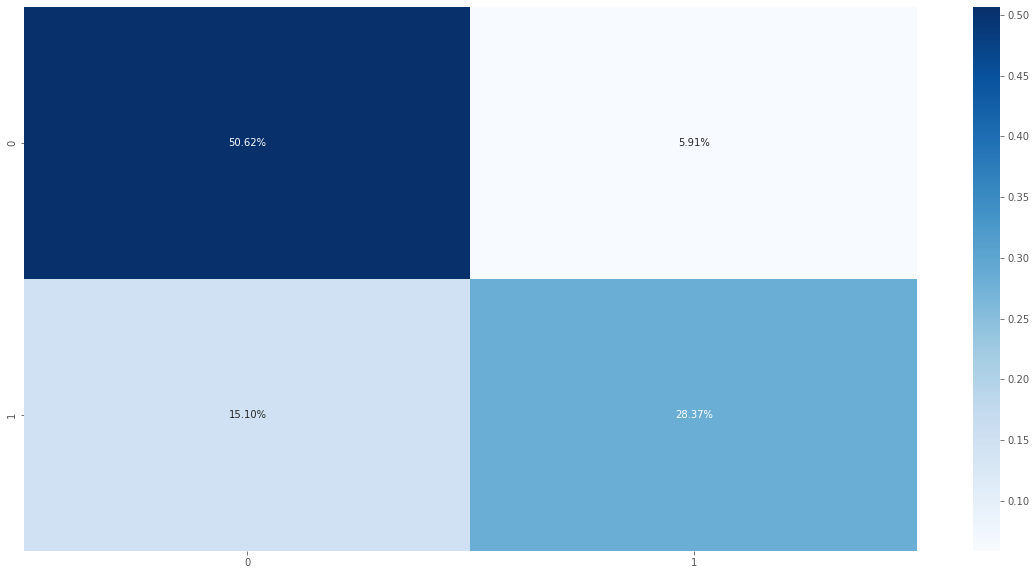

In [95]:
sns.heatmap(conf_matrix/np.sum(conf_matrix),annot=True, fmt='.2%', cmap='Blues')

Fitting the Test data for submission

In [96]:
test_vectorizer = tfidf.transform(data_clean_test['text_clean']).toarray()

In [97]:
test_vectorizer.shape

(3263, 5000)

In [98]:
final_predictions = mnb_classifier.predict(test_vectorizer)

In [99]:
final_predictions

array([1, 0, 0, ..., 1, 1, 1])

In [100]:
submission_df = pd.DataFrame()
submission_df['id'] = data_clean_test['id']
submission_df['target'] = final_predictions

In [101]:
submission_df

,id,target
0,0,1
1,2,0
2,3,0
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [102]:
submission_df['target'].value_counts()

0    2278
1     985
Name: target, dtype: int64